## Spam classifier

L'objectif dans ce notebook est de développer des modèles de classification capables de dire si un mail est un spam ou pas.\
J'effectue alors une analyse de données rapide, puis j'entaîne deux modèles de classification de référence qui sont dans ce cas : un modèle de **Logistic Regression** et un deuxième de **Xgboost classifier**.\
Ensuite, je passe à l'etape de réseaux de neuronnes ou j'introduis un modèle de deux couches (512, 256).

### Importer les packages et librairies utiles

In [1]:
## Data handling modules and libraries

import pandas as pd 
import numpy as np 

## Visualization modules and libraries 
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns

## models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.metrics import AUC
from keras.callbacks import EarlyStopping

## utils  
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('Data/spam.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_semicolon,char_freq_leftbrac,char_freq_leftsquarebrac,char_freq_exclaim,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [3]:
## plot the histogram of the spam value (target)

px.histogram(data, x = 'spam' , title = "Spam Histogram")

Puisque les données ne sont pas fortement déséquilibrées et que notre dataset a une forte dimension, il n'est pas très intéressant d'utilisant de méthode d'oversampling tel SMOTE. \
En revanche, nous pouvons jouer sur le paramètre 'class_weight' dans les modèles de base.

### Etude de corrélation et visualisation 

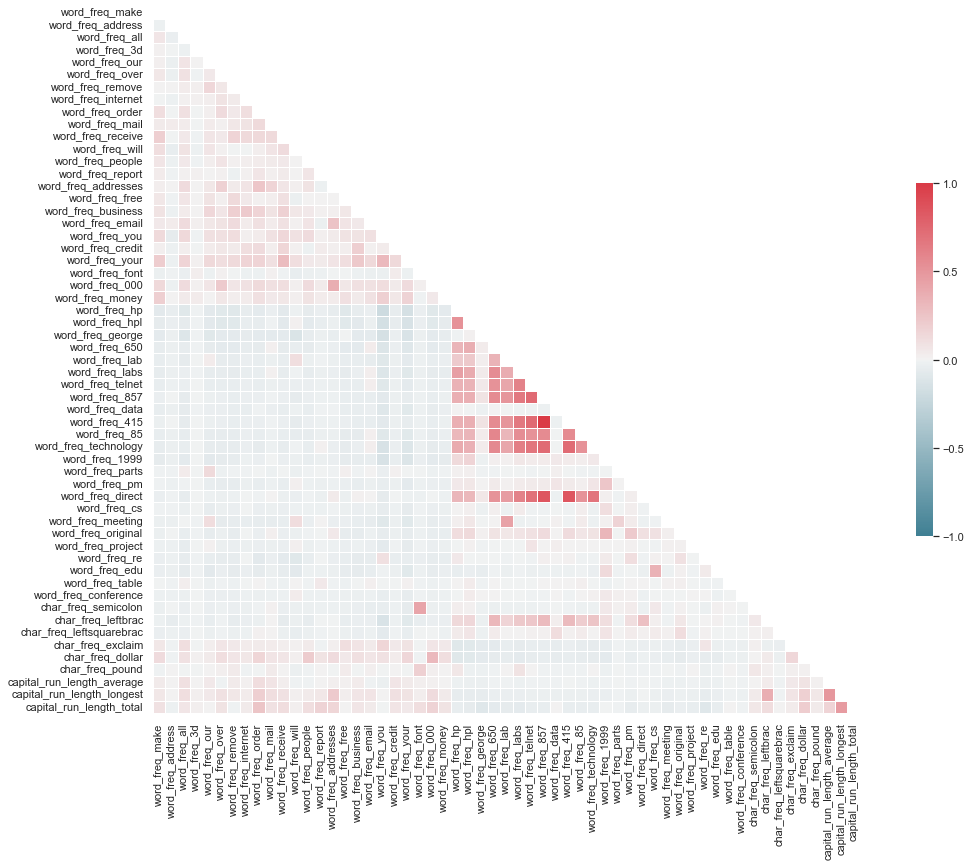

In [4]:

## correlation between all features 

sns.set(style="white", font_scale=1)
corr = data.drop(["spam"], axis = 1).corr() # .corr is used to find corelation

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax=sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cmap=cmap, cbar_kws={"shrink": .5})
cbar=ax.collections[0].colorbar
cbar.set_ticks([-1, -0.50, 0, 0.50, 1])

In [5]:
## drop features that have a correlation above 80% 

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.8)]
print(to_drop)  


['word_freq_415', 'word_freq_direct']


Nous remarquons ici que les deux colonnes ayant une corrélation (linéaire) supérieure à 80% sont 'word_freq_415', et 'word_freq_direct'. Il serait surprenant alors que cette corrélation ne soit pas un fait de hasard et que la présence de l'un des deux mots (415 ou direct) dans les mails induit une présence de l'autre. 

Il serait plus correct alors de garder les deux colonnes. 

In [6]:

## plot the correlation matrix between the new features and the target column 'default' 

corr = data.drop('spam', axis=1).corrwith(data['spam'])
corr_df = pd.DataFrame(corr).reset_index()
corr_df.columns = ["col" , "corr"]
px.bar(corr_df, x='col', y='corr', 
       title = "Correlation between features and spam Variable")

Premier résultat imporant que nous pouvons directement conclure est qu'aucune feature ne présente une corrélation linéaire très élevée avec la colonne de target. Toutefois, la colonne 'char_freq_dollar' présente tout de même une corrélation de 0.32, ceci peut inspirer que les mails de spam contiennet généralement des promotions ou des offres, et donc on peut constater par la suite une présence du terme (dollar ou $).


### Diviser les données en échantillons d'entraînement, de validation et de test

In [7]:
## split data into train, validation and test sets 

train, test = train_test_split(data, test_size = 0.20
                            , random_state= 42,stratify= data["spam"] )

train, valid = train_test_split(train, test_size = 0.4  
                            , random_state= 42,stratify= train["spam"] )

# Check dimensions
print('Training set shape: ',np.shape(train))
print('Validation set shape: ', np.shape(valid) )
print('Test set shape: ', np.shape(test))

print("Training set:")
print(f" + Non-defaulters (y=0): {len(train[train.spam==0])}")
print(f" + Defaulters (y=1):\t {len(train[train.spam ==1])}")

print("Validation set:")
print(f" + Non-defaulters (y=0): {len(valid[valid.spam==0])}")
print(f" + Defaulters (y=1):\t {len(valid[valid.spam ==1])}")

print("Test set:")
print(f" + Non-defaulters (y=0): {len(test[test.spam==0])}")
print(f" + Defaulters (y=1):\t {len(test[test.spam==1])}")

Training set shape:  (2208, 58)
Validation set shape:  (1472, 58)
Test set shape:  (921, 58)
Training set:
 + Non-defaulters (y=0): 1338
 + Defaulters (y=1):	 870
Validation set:
 + Non-defaulters (y=0): 892
 + Defaulters (y=1):	 580
Test set:
 + Non-defaulters (y=0): 558
 + Defaulters (y=1):	 363


### Normalisation de données 

In [8]:
X_train, y_train = train.drop('spam', axis = 1), train['spam']
X_valid, y_valid = valid.drop('spam', axis = 1), valid['spam']
X_test, y_test = test.drop('spam', axis = 1) , test['spam']

## usint a StandarScaler 
sc = StandardScaler()
X_train_scaled  = sc.fit_transform(X_train)
X_valid_scaled = sc.transform(X_valid)
X_test_scaled = sc.transform(X_test)


### Méthodes de base : Régression logistique, Xgboost classifier 

#### Logistic Regression 

Dans cette partie, nous lanssans un RandomizedSearch pour faire du tuning des hyperparamètres. Ici, nous ne considérons que la 'class_weight' que nous faisons varier : (1,2) , (1,1.5), (1,1).

In [9]:
## Training a logistic regression model

lr  = LogisticRegression()
param_grid = {'class_weight'  : [(1,2) , (1,1.5), (1,1)]}

## use roc_auc_score as evaluation score         
roc_auc = make_scorer(roc_auc_score)

## Running a RandomizedSearch for hyperparameters tuning
lr_RandomGrid = RandomizedSearchCV(estimator = lr, scoring= roc_auc , 
param_distributions = param_grid, cv = 10, verbose= 1 )

lr_RandomGrid.fit(X_valid_scaled, y_valid)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'class_weight': [(1, 2), (1, 1.5),
                                                         (1, 1)]},
                   scoring=make_scorer(roc_auc_score), verbose=1)

training roc_auc_score :  0.9096180609246947
training confusion matrix : 
 [[1273   65]
 [ 115  755]]
              -----               
test roc_auc_score : 0.9166444503687905
test confusion matrix :
 [[528  30]
 [ 41 322]]
              -----               


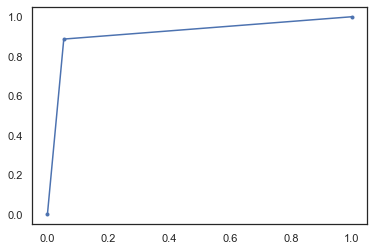

In [10]:
best_lr = lr_RandomGrid.best_estimator_

best_lr.fit(X_train_scaled, y_train)

# make predictions
y_pred = best_lr.predict(X_test_scaled)


print(f"training roc_auc_score :  {roc_auc_score(y_train, best_lr.predict(X_train_scaled)) }")
print(f"training confusion matrix : \n {confusion_matrix(y_train, best_lr.predict(X_train_scaled))}")
print('              -----               ')
## make predictions
y_pred = best_lr.predict(X_test_scaled)
print(f"test roc_auc_score : {roc_auc_score(y_test, y_pred)}")
print(f"test confusion matrix :\n {confusion_matrix(y_test, y_pred)}")
print('              -----               ')
# Plot the curve plot 
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Xgboost Classifier 

In [11]:
## Training a Xgboost classifier

xgb  = XGBClassifier()

class_weight = sum(data.spam == 0) / sum(data.spam == 1)
param_grid = {'scale_pos_weight'  : [class_weight], 
            "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
            "max_depth" : [2,4,6],
            "min_child_weight" : [ 1, 3, 5, 7 ],
            "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

## use roc_auc_score as evaluation score         
roc_auc = make_scorer(roc_auc_score)
warnings.filterwarnings("ignore", category=DeprecationWarning)
xgb_RandomGrid = RandomizedSearchCV(estimator = xgb, scoring= roc_auc , 
param_distributions = param_grid, cv = 10, verbose= 1 )

xgb_RandomGrid.fit(X_valid_scaled, y_valid) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'scale_pos_weight': [1.5377826806398236]},
                   scoring=make_scorer(roc_auc_score), verbose=1)

training roc_auc_score :  0.9725246121333951
training confusion matrix : 
 [[1306   32]
 [  27  843]]
              -----               
test roc_auc_score : 0.9418525430255635
test confusion matrix :
 [[530  28]
 [ 24 339]]
              -----               


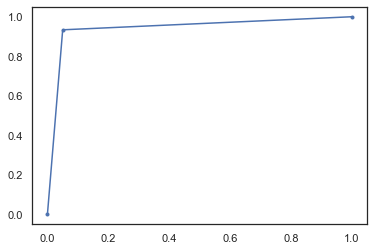

In [12]:
best_xgb = xgb_RandomGrid.best_estimator_

best_xgb.fit(X_train_scaled, y_train)

# make predictions
y_pred = best_xgb.predict(X_test_scaled)


print(f"training roc_auc_score :  {roc_auc_score(y_train, best_xgb.predict(X_train_scaled)) }")
print(f"training confusion matrix : \n {confusion_matrix(y_train, best_xgb.predict(X_train_scaled))}")
print('              -----               ')
## make predictions
y_pred = best_xgb.predict(X_test_scaled)
print(f"test roc_auc_score : {roc_auc_score(y_test, y_pred)}")
print(f"test confusion matrix :\n {confusion_matrix(y_test, y_pred)}")
print('              -----               ')
# Plot the curve plot 
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.show()

### Modèle de réseaux de neuronnes

In [13]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=[AUC(),])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               29696     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 161,281
Trainable params: 161,281
Non-trainable params: 0
_________________________________________________________________


In [14]:
# create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
## fit the model 
history=model.fit(X_train_scaled,y_train,batch_size=32,
                    epochs=100,verbose=1,
                    shuffle=True, callbacks= early_stopping, 
                    validation_data=(X_valid_scaled, y_valid)).history

Epoch 1/100
69/69 [==============================] - 2s 11ms/step - loss: 0.3446 - auc: 0.9292 - val_loss: 0.2098 - val_auc: 0.9754
Epoch 2/100
69/69 [==============================] - 0s 6ms/step - loss: 0.2326 - auc: 0.9662 - val_loss: 0.1924 - val_auc: 0.9781
Epoch 3/100
69/69 [==============================] - 0s 5ms/step - loss: 0.2046 - auc: 0.9735 - val_loss: 0.1856 - val_auc: 0.9785
Epoch 4/100
69/69 [==============================] - 0s 6ms/step - loss: 0.1810 - auc: 0.9783 - val_loss: 0.1794 - val_auc: 0.9801
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 0.1652 - auc: 0.9819 - val_loss: 0.1739 - val_auc: 0.9818
Epoch 6/100
69/69 [==============================] - 0s 6ms/step - loss: 0.1586 - auc: 0.9832 - val_loss: 0.1623 - val_auc: 0.9821
Epoch 7/100
69/69 [==============================] - 0s 5ms/step - loss: 0.1504 - auc: 0.9849 - val_loss: 0.1679 - val_auc: 0.9816
Epoch 8/100
69/69 [==============================] - 0s 6ms/step - loss: 0.1479 - 

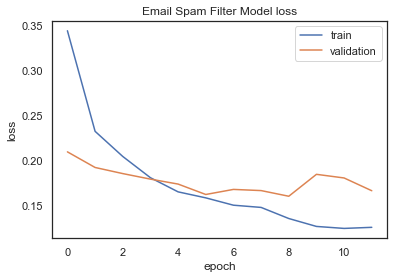

In [15]:
# plot the loss on train and validation data
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right') 

29/29 [==============================] - 0s 1ms/step
test roc_auc_score : 0.9321440208536982
test confusion matrix :
 [[533  25]
 [ 33 330]]
              -----               


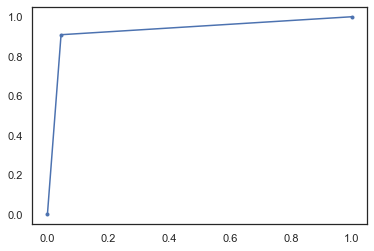

In [16]:
## make predictions
y_pred = model.predict(X_test_scaled)
y_pred = [round(e[0]) for e in y_pred]

print(f"test roc_auc_score : {roc_auc_score(y_test, y_pred)}")
print(f"test confusion matrix :\n {confusion_matrix(y_test, y_pred)}")
print('              -----               ')
# Plot the curve plot 
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.show()